<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to google

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# save_model_path = '/content/drive/MyDrive/DL for VR/Project/Models' # Thomas
#save_model_path = '/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/' # Morten
save_model_path = '/content/drive/MyDrive/Visual reg' # Mads


Mounted at /content/drive


In [2]:
!git clone https://github.com/mortgad/DLVR.git
%cd DLVR

Cloning into 'DLVR'...
remote: Enumerating objects: 494, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 494 (delta 89), reused 73 (delta 70), pack-reused 384 (from 1)
Receiving objects: 100% (494/494), 56.83 MiB | 36.39 MiB/s, done.
Resolving deltas: 100% (275/275), done.
/content/DLVR


In [3]:
from utils.utkface import load_utkface
load_utkface()

from utils.utkface import preprocess_utkface
df_utkface, df_utkface_raw = preprocess_utkface()

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz
Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg
Deleted: /content/extracted/part3/.DS_Store
Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg
Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg
Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


# Get data for modelling


In [4]:
df_utkface_raw.head()

file  age_raw  gender_code  \
0  /content/extracted/part1/59_0_0_20170111201348...       59            0   
1  /content/extracted/part1/41_0_4_20170104205417...       41            0   
2  /content/extracted/part1/7_1_1_201701091931144...        7            1   
3  /content/extracted/part1/66_1_0_20170105174521...       66            1   
4  /content/extracted/part1/1_1_2_201612192034249...        1            1   

   race_code    age  age_code  gender    race  
0          0  50-59         6    Male   White  
1          4  40-49         5    Male  Others  
2          1    3-9         1  Female   Black  
3          0  60-69         7  Female   White  
4          2    0-2         0  Female   Asian

In [5]:
# Drop not needed colums:
df = df_utkface_raw[['age_raw','gender_code','race_code','file']]

df = df[df['age_raw']<=100]

df.rename(columns={'age_raw': 'age_code'}, inplace=True)
#df['age_code'] = df['age_code'].astype(float)
# df.rename(columns={'gender': 'gender_code'}, inplace=True)
# df.rename(columns={'race': 'race_code'}, inplace=True)

<ipython-input-5-1f533c0ed205>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'age_raw': 'age_code'}, inplace=True)


In [6]:
from utils.preprocessing import create_lists

images, ages, races, genders = create_lists(df)
print(f"Loaded {len(images)} images.")

# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))
print(f"Number of age classes: {num_classes_age}")
print(f"Number of gender classes: {num_classes_gender}")
print(f"Number of ethnicity classes: {num_classes_ethnicity}")

Processing images:   0%|          | 0/24079 [00:00<?, ?it/s]

Loaded 24079 images.
Number of age classes: 97
Number of gender classes: 2
Number of ethnicity classes: 5


In [7]:
from sklearn.model_selection import train_test_split
from keras.applications.resnet_v2 import preprocess_input

images_preprocessed = preprocess_input(images)

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(images_preprocessed, ages, races, genders, test_size=0.20, random_state=42, stratify=ages)

# Split temp into validation (75% of temp, which is 15% of original data) and test (25% of temp, which is 5% of original data)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.25, random_state=42)


print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

Training set: (19263, 224, 224, 3), Training labels: (19263,)
Age validation set: (3612, 224, 224, 3), Age validation labels: (3612,)
Age test set: (1204, 224, 224, 3), Age test labels: (1204,)
Race validation labels: (3612,)
Race test labels: (1204,)
Gender validation labels: (3612,)
Gender test labels: (1204,)


# Fine-tuning


## Block 5

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = True

# Find the index of 'conv4_block6_out'
layer_name = 'conv4_block6_out'
layer_index = None

for idx, layer in enumerate(conv_base.layers):
    if layer.name == layer_name:
        layer_index = idx
        print(f"Found layer '{layer_name}' at index {layer_index}")
        break

if layer_index is None:
    raise ValueError(f"Layer '{layer_name}' not found in conv_base.")

# Freeze all layers before and including 'conv4_block6_out'
for layer in conv_base.layers[:layer_index + 1]:
    layer.trainable = False

# Unfreeze all layers after 'conv4_block6_out'
for layer in conv_base.layers[layer_index + 1:]:
    layer.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Verify the trainable status
for idx, layer in enumerate(conv_base.layers):
    print(f"Layer {idx}: {layer.name}, Trainable: {layer.trainable}")

94668760/94668760 [==============================] - 0s 0us/step
Found layer 'conv4_block6_out' at index 153
Layer 0: input_1, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: pool1_pad, Trainable: False
Layer 4: pool1_pool, Trainable: False
Layer 5: conv2_block1_preact_bn, Trainable: False
Layer 6: conv2_block1_preact_relu, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_pad, Trainable: False
Layer 11: conv2_block1_2_conv, Trainable: False
Layer 12: conv2_block1_2_bn, Trainable: False
Layer 13: conv2_block1_2_relu, Trainable: False
Layer 14: conv2_block1_0_conv, Trainable: False
Layer 15: conv2_block1_3_conv, Trainable: False
Layer 16: conv2_block1_out, Trainable: False
Layer 17: conv2_block2_preact_bn, Trainable: False
Layer 18: conv2_block2_preact_relu, Trainable: False
Layer 19: conv2_block2_1_conv, 

In [ ]:
# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
from tensorflow.keras import layers

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048  

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_finetune_block_5.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/20
602/602 [==============================] - ETA: 0s - loss: 1398.5415 - mae: 32.3891
Epoch 1: val_mae improved from inf to 31.03643, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5.keras
602/602 [==============================] - 403s 662ms/step - loss: 1398.5415 - mae: 32.3891 - val_loss: 1243.3777 - val_mae: 31.0364
Epoch 2/20
602/602 [==============================] - ETA: 0s - loss: 1104.0143 - mae: 28.9906
Epoch 2: val_mae improved from 31.03643 to 26.56076, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5.keras
602/602 [==============================] - 396s 659ms/step - loss: 1104.0143 - mae: 28.9906 - val_loss: 924.7162 - val_mae: 26.5608
Epoch 3/20
602/602 [==============================] - ETA: 0s - loss: 871.4423 - mae: 25.6012
Epoch 3: val_mae improved from 26.56076 to 22.72719, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5.keras
602/602 [==================

Best Training MAE: 5.9783
Best Validation MAE: 7.0483
Best Training Loss: 61.8267
Best Validation Loss: 101.8201


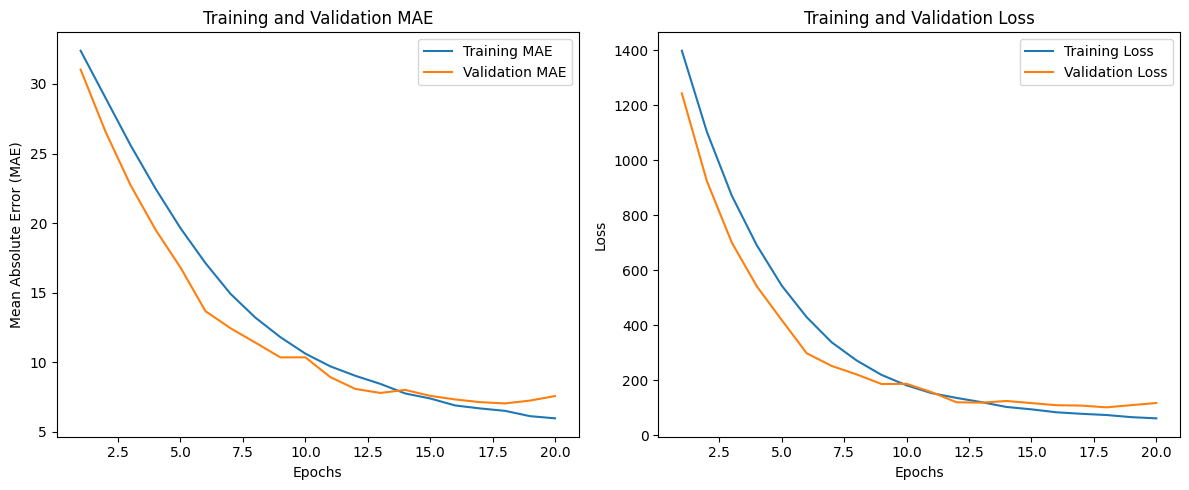

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

## Block 5+4

In [19]:
from keras.applications.resnet_v2 import preprocess_input
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np

# Assume 'images_preprocessed' is already defined and contains your preprocessed images
input_shape = (
    images_preprocessed[0].shape[0],
    images_preprocessed[0].shape[1],
    images_preprocessed[0].shape[2]
)

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
)
conv_base.trainable = True

# Reset all layers to non-trainable
for layer in conv_base.layers:
    layer.trainable = False

# Find the index of 'conv3_block4_out'
layer_name = 'conv3_block4_out'
layer_index = None

for idx, layer in enumerate(conv_base.layers):
    if layer.name == layer_name:
        layer_index = idx
        print(f"Found layer '{layer_name}' at index {layer_index}")
        break

if layer_index is None:
    raise ValueError(f"Layer '{layer_name}' not found in conv_base.")

# Freeze all layers before and including 'conv3_block4_out'
for layer in conv_base.layers[:layer_index + 1]:
    layer.trainable = False

# Unfreeze all layers after 'conv3_block4_out'
for layer in conv_base.layers[layer_index + 1:]:
    layer.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Verify the trainable status
print("\nTrainable status after processing 'conv3_block4_out':")
for idx, layer in enumerate(conv_base.layers):
    print(f"Layer {idx}: {layer.name}, Trainable: {layer.trainable}")

94668760/94668760 [==============================] - 0s 0us/step
Found layer 'conv3_block4_out' at index 85

Trainable status after processing 'conv3_block4_out':
Layer 0: input_1, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: pool1_pad, Trainable: False
Layer 4: pool1_pool, Trainable: False
Layer 5: conv2_block1_preact_bn, Trainable: False
Layer 6: conv2_block1_preact_relu, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_pad, Trainable: False
Layer 11: conv2_block1_2_conv, Trainable: False
Layer 12: conv2_block1_2_bn, Trainable: False
Layer 13: conv2_block1_2_relu, Trainable: False
Layer 14: conv2_block1_0_conv, Trainable: False
Layer 15: conv2_block1_3_conv, Trainable: False
Layer 16: conv2_block1_out, Trainable: False
Layer 17: conv2_block2_preact_bn, Trainable: False
Layer 18: conv2_block2_preact_

In [20]:
# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
from tensorflow.keras import layers

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048  

In [21]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_finetune_block_5_4.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/30
602/602 [==============================] - ETA: 0s - loss: 1327.1212 - mae: 31.2553
Epoch 1: val_mae improved from inf to 28.99125, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5_4.keras
602/602 [==============================] - 554s 909ms/step - loss: 1327.1212 - mae: 31.2553 - val_loss: 1100.1271 - val_mae: 28.9912
Epoch 2/30
602/602 [==============================] - ETA: 0s - loss: 1030.3745 - mae: 27.9480
Epoch 2: val_mae improved from 28.99125 to 24.44377, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5_4.keras
602/602 [==============================] - 550s 914ms/step - loss: 1030.3745 - mae: 27.9480 - val_loss: 795.6121 - val_mae: 24.4438
Epoch 3/30
602/602 [==============================] - ETA: 0s - loss: 791.9490 - mae: 24.4121
Epoch 3: val_mae improved from 24.44377 to 18.96034, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5_4.keras
602/602 [============

Best Training MAE: 3.5653
Best Validation MAE: 6.0516
Best Training Loss: 21.7813
Best Validation Loss: 77.2773


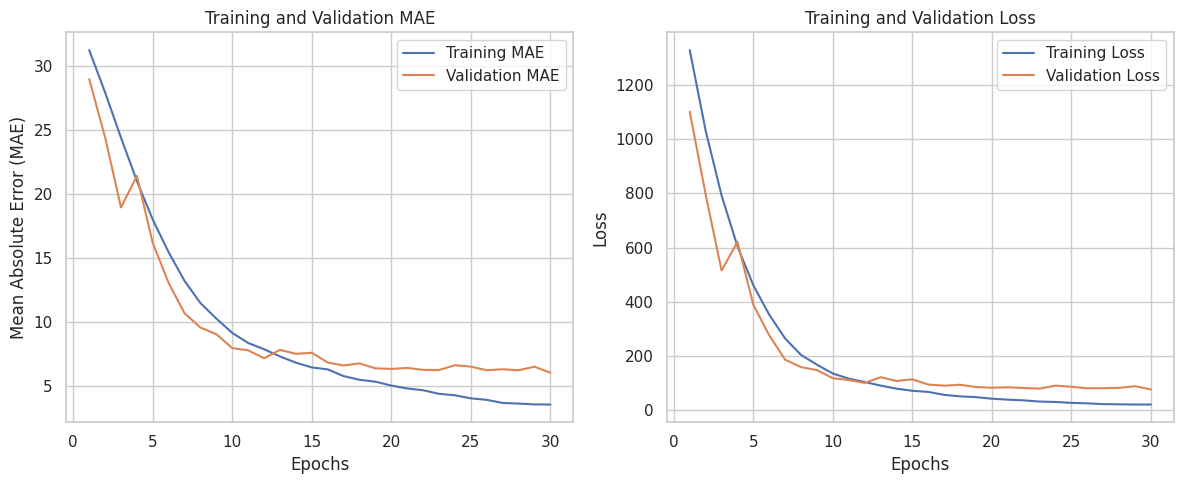

In [22]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

# Testing the best model

In [23]:
from tensorflow.keras.models import load_model

# Define the file path and model name
file_path = '/content/drive/MyDrive/Visual reg/'
model_name = 'resnet50v2_model_finetune_block_5_4.keras'

# Load the model
model = load_model(file_path + model_name)

# Evaluate the model
loss, mae = model.evaluate(X_val, y_val_age, verbose=1)
print(f"Validation Loss (MSE): {loss}")
print(f"Validation MAE: {mae}")

113/113 [==============================] - 46s 389ms/step - loss: 77.2773 - mae: 6.0516
Validation Loss (MSE): 77.27729034423828
Validation MAE: 6.05156135559082


In [24]:
# Predict ages on validation data
y_pred_age = model.predict(X_val).flatten()

113/113 [==============================] - 45s 387ms/step


In [38]:
import pandas as pd
df_val = pd.DataFrame({
    'y_true_age': y_val_age,
    'y_pred_age': y_pred_age,
    'gender_code': y_val_gender,
    'race_code': y_val_races
})

In [39]:
# Extract unique mappings for gender and race
gender_mapping = df_utkface_raw[['gender_code', 'gender']].drop_duplicates()
race_mapping = df_utkface_raw[['race_code', 'race']].drop_duplicates()

# Create dictionaries for mapping
gender_dict = dict(zip(gender_mapping['gender_code'], gender_mapping['gender']))
race_dict = dict(zip(race_mapping['race_code'], race_mapping['race']))

# Map codes to labels in the validation DataFrame
df_val['gender'] = df_val['gender_code'].map(gender_dict)
df_val['race'] = df_val['race_code'].map(race_dict)

In [40]:
# Calculate absolute error
df_val['abs_error'] = abs(df_val['y_true_age'] - df_val['y_pred_age'])

# MAE across genders
gender_mae = df_val.groupby('gender')['abs_error'].mean().reset_index()

# MAE across races
race_mae = df_val.groupby('race')['abs_error'].mean().reset_index()

In [41]:
df_val.sort_values(by='abs_error', ascending=False, inplace=True)

In [54]:
df_val[:20]

y_true_age  y_pred_age  gender_code  race_code  gender    race  \
73            90   12.811492            0          0    Male   White   
435           87   31.663671            0          0    Male   White   
762           65   14.549710            1          0  Female   White   
430            3   52.963337            1          0  Female   White   
2676           5   53.841461            1          0  Female   White   
2929           8   55.338272            0          0    Male   White   
2810           9   51.672859            0          0    Male   White   
2867           1   43.582642            1          3  Female  Indian   
1591          62   19.600285            1          1  Female   Black   
906           11   53.302906            1          0  Female   White   
2215          80   38.616421            1          0  Female   White   
1200          60   18.680756            1          0  Female   White   
2793          15   55.366310            0          0    Male   White   
3569          78   37.967690            0          0    Male   White   
773            8   47.359207            1          0  Female   White   
2681          85   45.943710            1          0  Female   White   
225           59   21.548841            1          1  Female   Black   
1502          75   38.364262            0          2    Male   Asian   
28            90   54.404526            0          1    Male   Black   
3206          14   48.417007            0          0    Male   White   

      abs_error  
73    77.188508  
435   55.336329  
762   50.450290  
430   49.963337  
2676  48.841461  
2929  47.338272  
2810  42.672859  
2867  42.582642  
1591  42.399715  
906   42.302906  
2215  41.383579  
1200  41.319244  
2793  40.366310  
3569  40.032310  
773   39.359207  
2681  39.056290  
225   37.451159  
1502  36.635738  
28    35.595474  
3206  34.417007

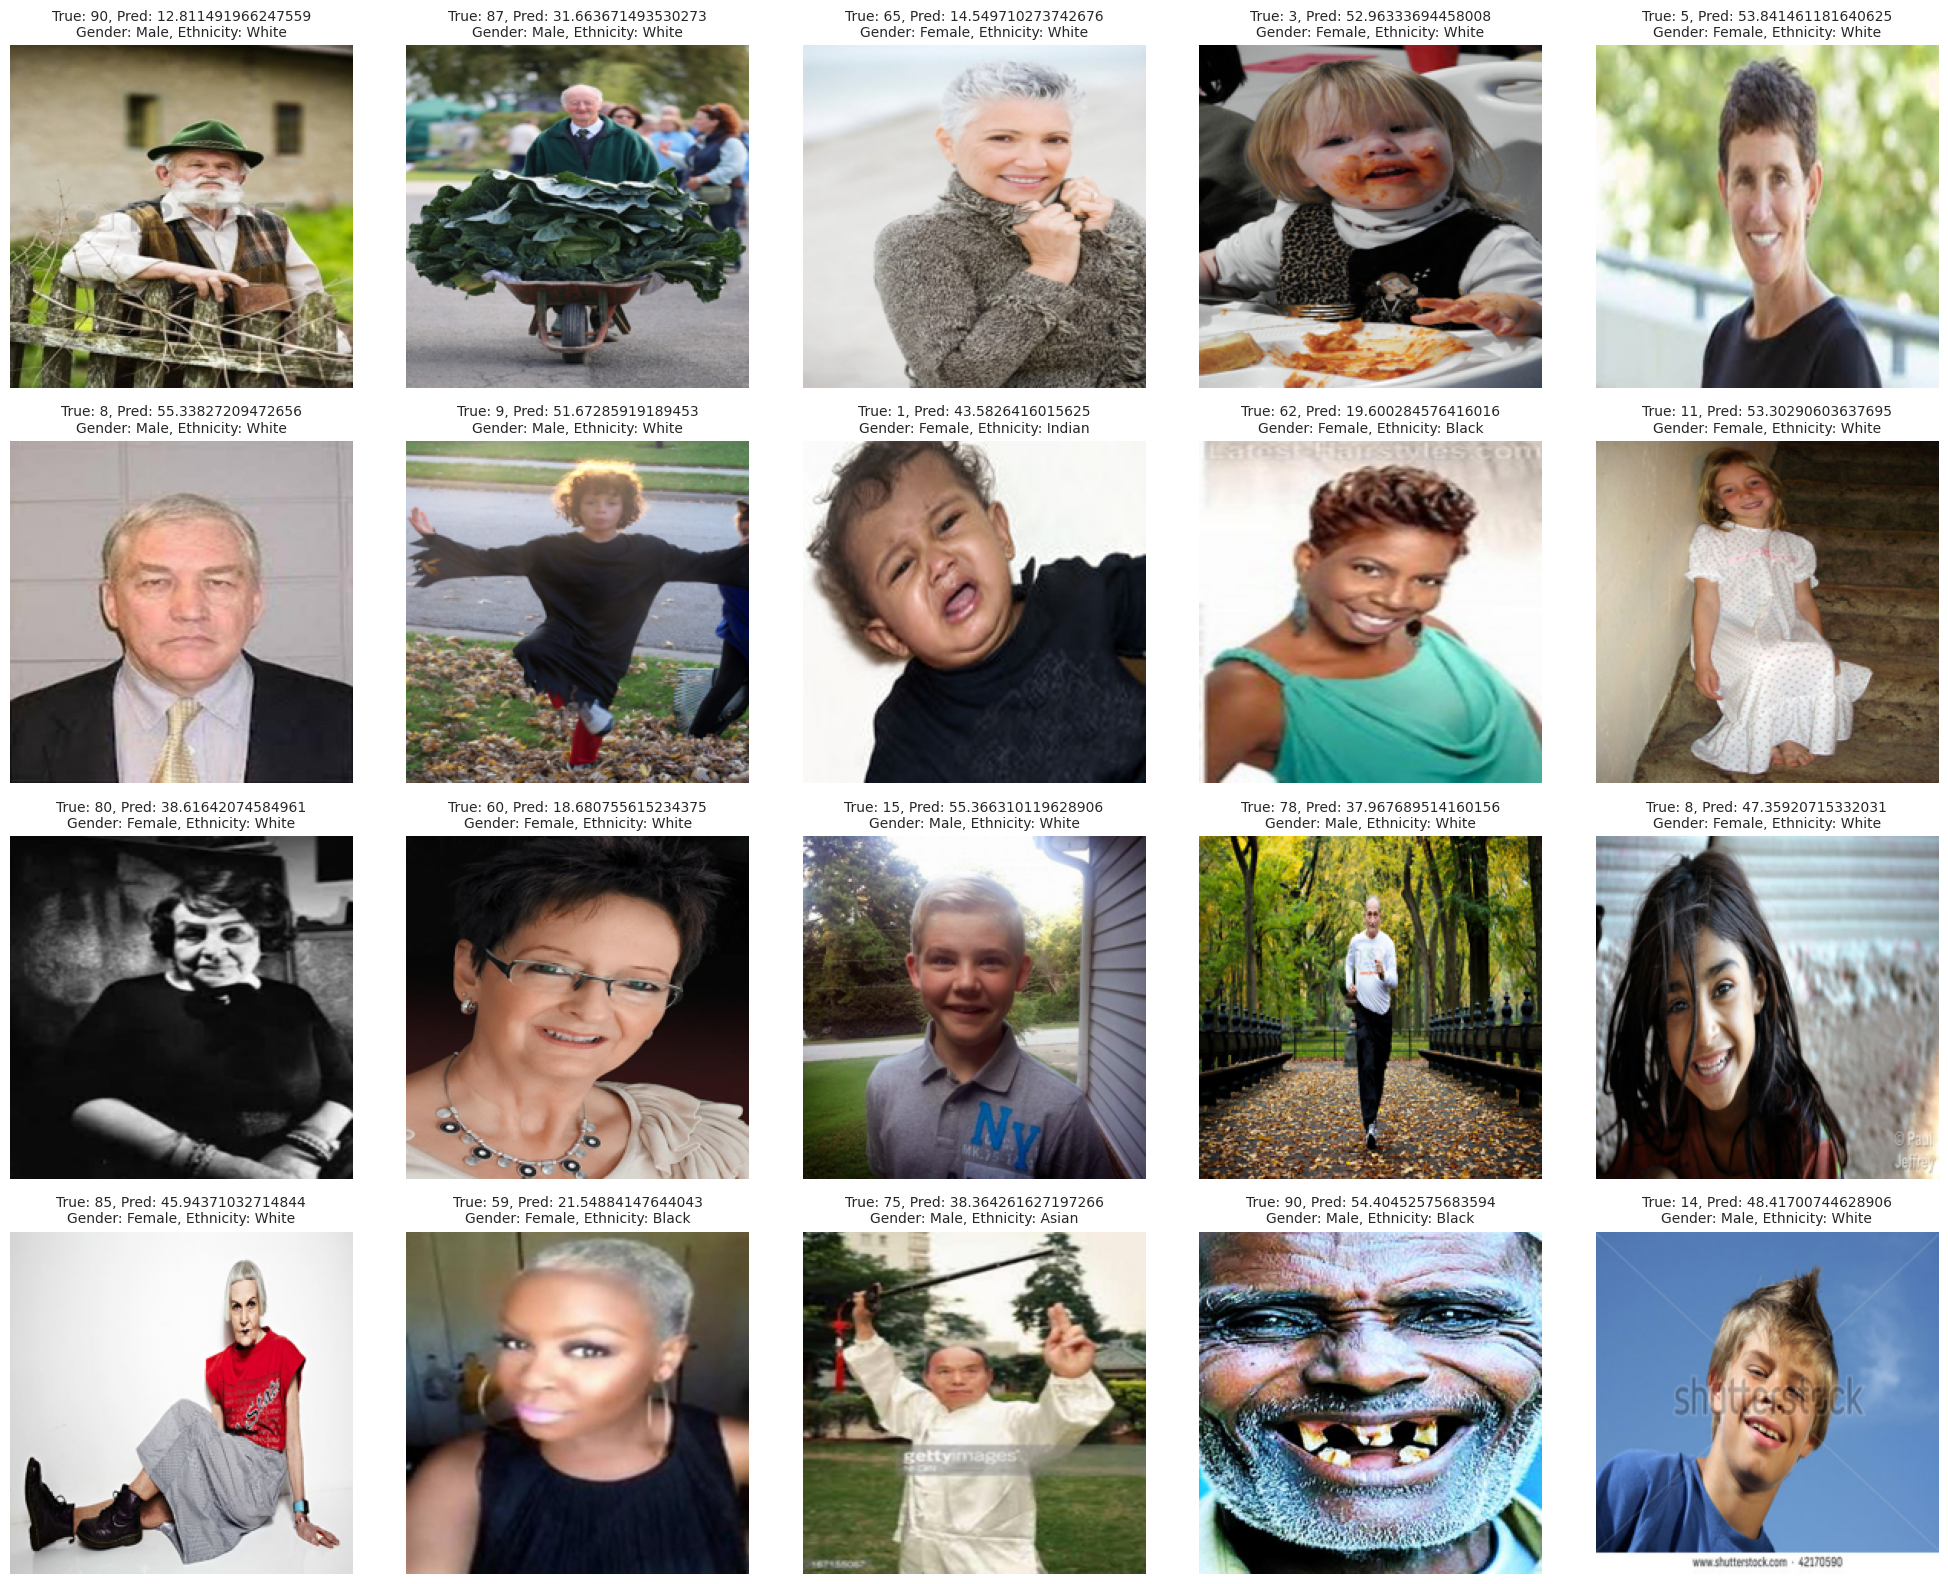

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_val[:20] provides the indices of the worst-performing images
worst_indices = df_val[:20].index

# Create a larger grid to display 20 images (4x5 grid) with bigger pictures
fig, axes = plt.subplots(4, 5, figsize=(20, 16))  # Adjust figsize for larger images

for i, ax in enumerate(axes.flat):
    if i < len(worst_indices):
        # Get the image index
        image_index = worst_indices[i]
        image = X_val[image_index]

        # Rescale for display
        image_rescaled = (image - np.min(image)) / (np.max(image) - np.min(image))

        # Retrieve additional information
        true_age = df_val.loc[image_index, 'y_true_age']
        pred_age = df_val.loc[image_index, 'y_pred_age']
        gender = df_val.loc[image_index, 'gender']  # Use mapped gender
        ethnicity = df_val.loc[image_index, 'race']  # Use mapped race

        # Show the image
        ax.imshow(image_rescaled)
        ax.axis('off')

        # Set the title with additional details
        ax.set_title(f"True: {true_age}, Pred: {pred_age}\nGender: {gender}, Ethnicity: {ethnicity}", fontsize=10)
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

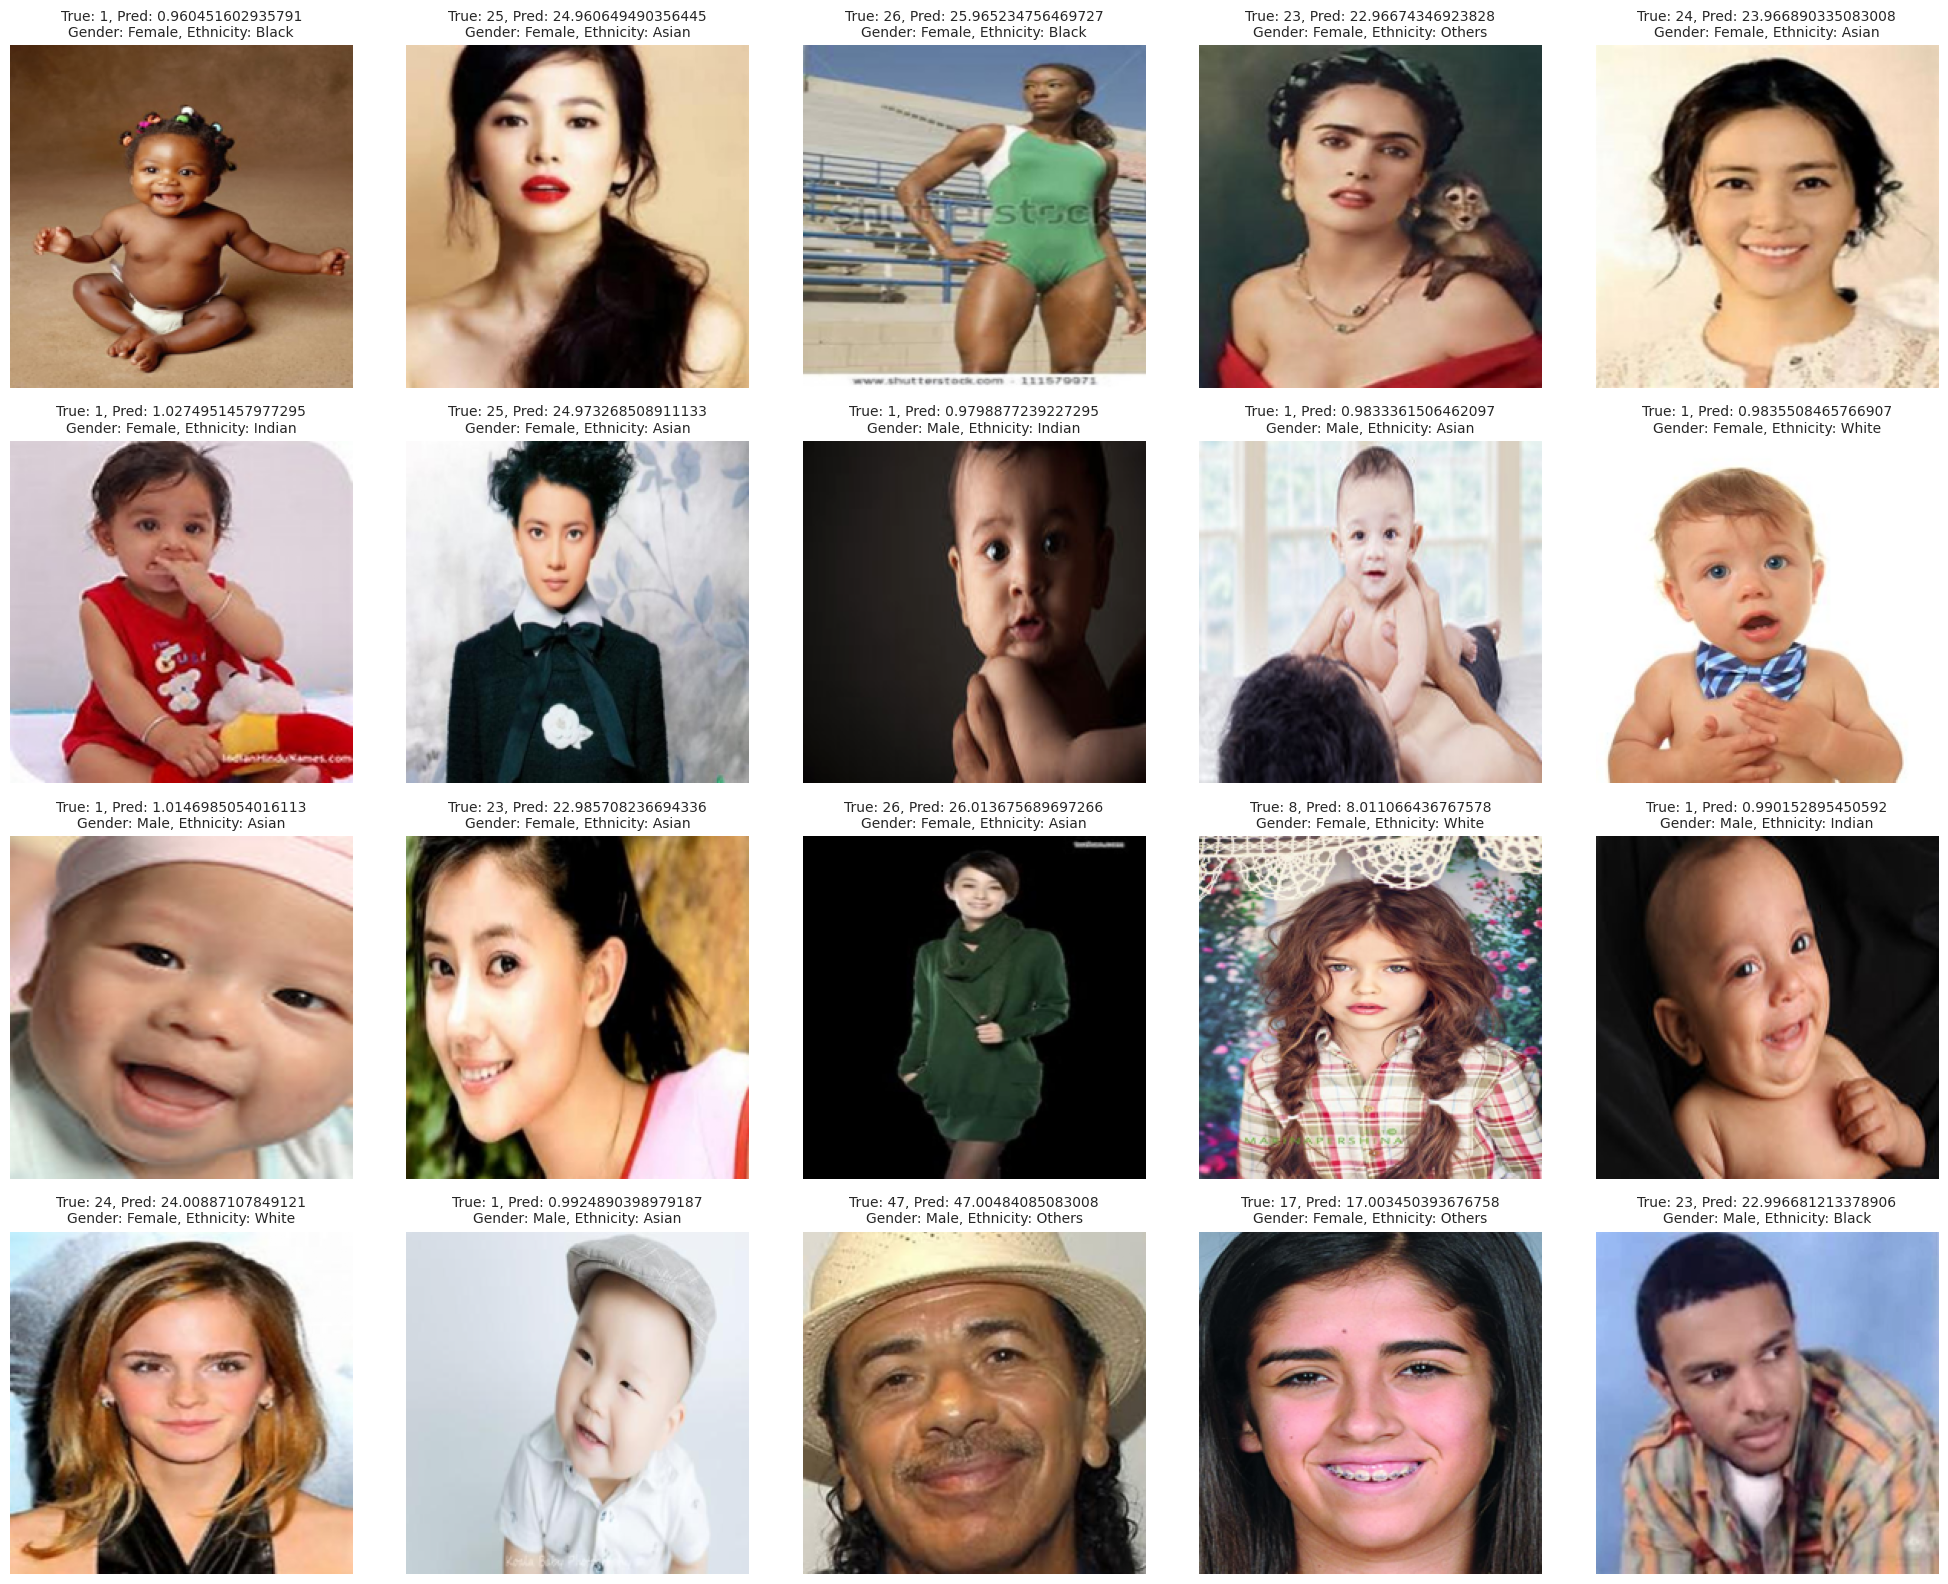

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_val[:20] provides the indices of the worst-performing images
worst_indices = df_val[-20:].index

# Create a larger grid to display 20 images (4x5 grid) with bigger pictures
fig, axes = plt.subplots(4, 5, figsize=(20, 16))  # Adjust figsize for larger images

for i, ax in enumerate(axes.flat):
    if i < len(worst_indices):
        # Get the image index
        image_index = worst_indices[i]
        image = X_val[image_index]

        # Rescale for display
        image_rescaled = (image - np.min(image)) / (np.max(image) - np.min(image))

        # Retrieve additional information
        true_age = df_val.loc[image_index, 'y_true_age']
        pred_age = df_val.loc[image_index, 'y_pred_age']
        gender = df_val.loc[image_index, 'gender']  # Use mapped gender
        ethnicity = df_val.loc[image_index, 'race']  # Use mapped race

        # Show the image
        ax.imshow(image_rescaled)
        ax.axis('off')

        # Set the title with additional details
        ax.set_title(f"True: {true_age}, Pred: {pred_age}\nGender: {gender}, Ethnicity: {ethnicity}", fontsize=10)
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

In [65]:
gender_mae

gender  abs_error
0  Female   6.245277
1    Male   5.874282

In [31]:
race_mae

race  abs_error
0   Asian   4.483727
1   Black   6.705538
2  Indian   6.002454
3  Others   4.458217
4   White   6.565794

<ipython-input-32-ad8a8bcd15e0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='abs_error', data=gender_mae, palette='viridis')


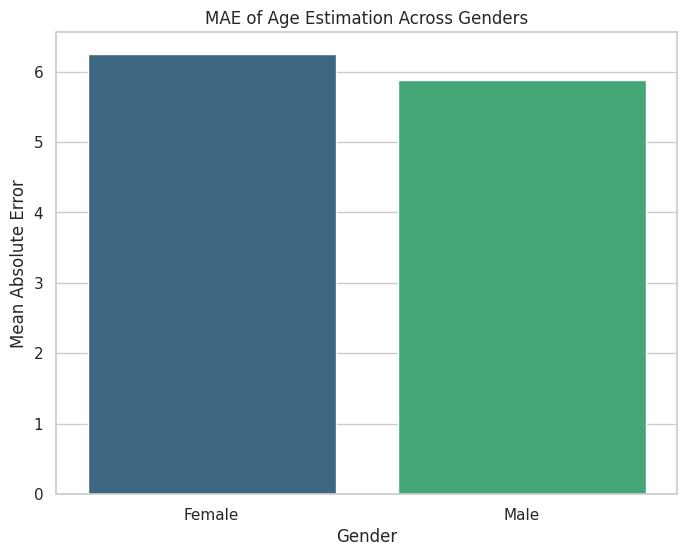

<ipython-input-32-ad8a8bcd15e0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='race', y='abs_error', data=race_mae, palette='magma')


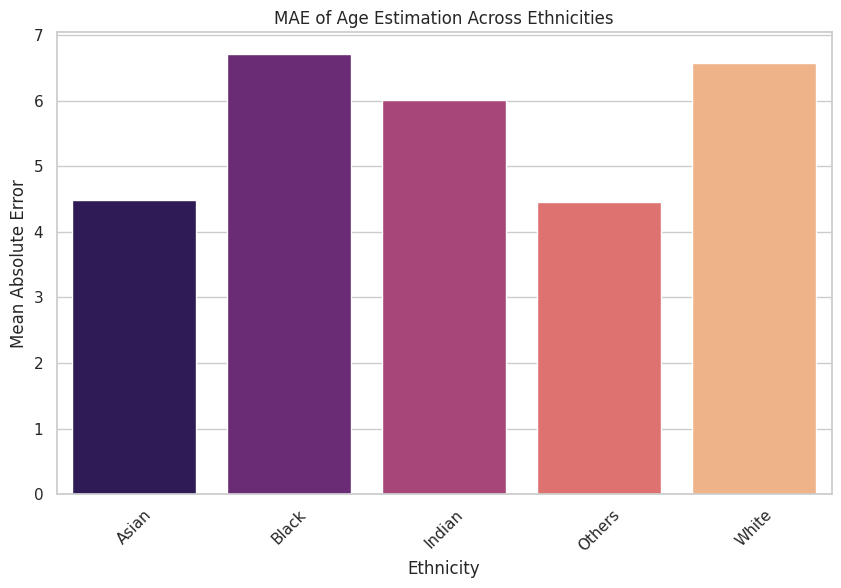

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot MAE across genders
plt.figure(figsize=(8,6))
sns.barplot(x='gender', y='abs_error', data=gender_mae, palette='viridis')
plt.title('MAE of Age Estimation Across Genders')
plt.xlabel('Gender')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot MAE across races
plt.figure(figsize=(10,6))
sns.barplot(x='race', y='abs_error', data=race_mae, palette='magma')
plt.title('MAE of Age Estimation Across Ethnicities')
plt.xlabel('Ethnicity')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.show()